<(자발방출 채널) + (BBR 유도 하향 추가분) + (BBR 상향) + (충돌) 을 합산 계산>


셀 1 — 준비/헬퍼  
make_atom(name): ARC의 Caesium / Rubidium 객체 생성.
l_to_letter(l): l→문자(S,P,D,…) 변환.
state_str(s): (n,l,j) 튜플을 사람 읽기 포맷으로.
in_window(lam_m, win): 파장(미터)이 주어진 윈도우(예: 500–600 nm)에 들어오는지 검사.
allowed_lowers(atom, s, n_floor): 현재 상태 s에서 허용된 하향(E1) 전이 후보 목록 산출(선택규칙 적용, n 하한 등 고려).
cascade_once(atom, start, max_steps): 시작 상태에서 캐스케이드 한 번 시뮬레이션 → 방출된 파장 리스트 반환.
spectrum_mc(atom, start, shots, max_steps): 위 과정을 Monte Carlo로 shots번 반복 → 전체 파장 스펙트럼 배열 반환.


가시권 수율이 낮게 나오는 이유(예: 0.0335/여기)
물리적으로도 타당한 면이 큽니다.
시작 상태가 낮은 n=14 P₃/₂라 IR/근적외선으로 떨어지는 경로가 다수일 수 있어요.
500–600 nm는 화학종·상태에 따라 분기비가 작은 구간입니다.
MAX_STEPS=10에서 조기 소멸/탈출(바닥상태 도달, 선택규칙으로 가시권 경로 희박)이 흔함.
(만약 반영했다면) 스핀-궤도/초미세구조/블랙바디 유도 전이가 실제 분기비를 더 바깥으로 퍼뜨립니다.
→ 결과적으로 “여기 1회당 가시권 광자 수”가 수 % 이하로 나오는 것이 이상하지 않습니다.

난수/샷 수
SEED=7로 고정. SHOTS가 작으면 라인 강도가 요동합니다(히스토그램 잡음↑). 수율의 절대값 자체도 분산이 큼.

""바로 적용 가능한 개선 팁""
물리/매개변수 쪽
시작 상태 상향: 더 높은 n(예: 20–30대)·적절한 l/j 조합으로 바꾸면 가시권 분기 채널이 더 열릴 수 있어요.
가시 윈도 확장: 450–700 nm 같은 넓은 구간에서 먼저 총 수율을 보고, 라인별로 좁혀가기.
MAX_STEPS 증가: 10→20~30으로 늘려 긴 캐스케이드를 허용(단, 계산량↑).
블랙바디/충돌효과 모형화: ARC의 흑체복사 전이율/수명 기능을 반영하면 분기 경로가 바뀜(온도↑일 때 가시권 채널이 늘 수도/줄 수도).
화학종 비교: Rb/Cs 비교해 가시권 라인 풍부한 쪽으로 선택.
코드/통계 쪽
SHOTS를 1e5 이상으로 키워 분산 줄이기.
visible_yield = vis_count / SHOTS는 “여기당 평균 가시광자 수” 정의로 맞습니다. 다만 총 방출 광자 수가 > SHOTS일 수 있으니, 캐스케이드당 총광자수도 함께 로깅해 해석을 돕는 게 좋아요.
히스토그램은 bin=0.5 nm 또는 적응형 binning으로 좁은 라인을 더 잘 분리.

In [20]:
import math, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from arc import Caesium, Rubidium  # 원자 선택

# 사용자 설정
ATOM = "Cs"                         # "Cs" 또는 "Rb"
START_STATE = (14, 1, 1.5)          # (n, l, j) 예: 14P3/2 → (14,1,1.5)
SHOTS = 10000                       # Monte Carlo 샷(커질수록 매끄러움↑)
MAX_STEPS = 10                      # 캐스케이드 최대 단계
VISIBLE_WINDOW = (500e-9, 600e-9)   # 500–600 nm
SEED = 7
random.seed(SEED)

def make_atom(name="Cs"):
    return Caesium() if name.lower() in ("cs","caesium","cesium") else Rubidium()

def l_to_letter(l):
    return "SPDFGH"[l] if l < 6 else f"L{l}"

def state_str(s):
    n,l,j = s
    return f"{n}{l_to_letter(l)}_{int(2*j)}/2"

def in_window(lam_m, win):
    return lam_m>0 and (win[0] <= lam_m <= win[1])


# ---- Collisions: helpers & parameters ----
kB = 1.380649e-23

def number_density(P_Pa, T_K):
    return P_Pa/(kB*T_K)             # [m^-3]

def mean_speed(T_K, mu_kg):
    return (8*kB*T_K/(math.pi*mu_kg))**0.5  # [m/s]

def collisional_rate(P_Pa, T_K, mu_kg, sigma_m2):
    # Γ_col = n_gas * <v_rel> * σ
    return number_density(P_Pa, T_K) * mean_speed(T_K, mu_kg) * sigma_m2

# 실험 조건(예시값 —  실험/문헌에 맞게 조정)
TEMP_C = 50.0
TEMP_K = 273.15 + TEMP_C
P_Pa   = 0.0          # 버퍼가스 압력 [Pa] (없으면 0)
MU_KG  = 1.0          # 환산질량 [kg] (원자-버퍼쌍)



셀 2 — 가능한 하향 전이/전이율, 1회 캐스케이드, 스펙트럼 생성


########### 충돌 팁 ##################


In [21]:
ALLOW_UPWARD = True  # BBR 상향 허용
SIGMA_LMIX   = 1e-18     # l-mixing 총 단면적(예: 1e-18 m^2)

# 자발방출+하향 흑체복사(BBR)
def allowed_lowers(atom, s, n_floor=5, temperature=0.0, include_same_n=True):
    n,l,j = s
    outs = []
    n_hi = n if include_same_n else (n-1)  # Δn=0 포함 권장
    for lp in (l-1, l+1):
        if lp < 0: 
            continue
        for jp in (lp-0.5, lp+0.5):
            if jp <= 0:
                continue
            for np_ in range(max(n_floor,5), n_hi+1):
                try:
                    A = atom.getTransitionRate(n,l,j, np_,lp,jp, temperature=temperature)
                except Exception:
                    A = 0.0
                if A > 0:
                    outs.append(((np_,lp,jp), A))
    return outs

# 추가: 상향 흑체복사 BBR 
def allowed_upward(atom, s, n_span_up=3, temperature=0.0):
    n,l,j = s
    outs = []
    # 상향 후보: n .. n+n_span_up (E1 선택규칙 준수)
    for lp in (l-1, l+1):
        if lp < 0:
            continue
        for jp in (lp-0.5, lp+0.5):
            if jp <= 0:
                continue
            for np_ in range(n, n + max(1, n_span_up) + 1):
                try:
                    # 에너지 방향을 체크해서 '진짜 상향'만 포함
                    Ei = atom.getEnergy(n,l,j)
                    Ef = atom.getEnergy(np_,lp,jp)
                    if Ef <= Ei:
                        continue  # 상향만
                    A_eff = atom.getTransitionRate(n,l,j, np_,lp,jp, temperature=temperature)
                except Exception:
                    A_eff = 0.0
                if A_eff > 0.0:
                    # 상향은 광자 방출 없음 -> 파장 None 표기
                    outs.append(((np_,lp,jp), A_eff, None))
    return outs

# collision channels
 # 고정 타깃으로 ‘소광/상태변환’
def collision_channels_fixed(s, sigma_dict):
    """
    sigma_dict: { (n2,l2,j2): sigma_m2, ... } 로 '이 상태로' 충돌 점프
    충돌은 광자 방출이 없으니 lam=None으로 둡니다.
    """
    chans = []
    if not sigma_dict:
        return chans
    for t, sigma in sigma_dict.items():
        rate = collisional_rate(P_Pa, TEMP_K, MU_KG, sigma)
        if rate > 0.0:
            chans.append((t, rate, None))  # (to_state, rate, lam=None)
    return chans

 # l-mixing (같은 n에서 l만 바꾸는 충돌) 자동 생성
def collision_channels_lmix(atom, s, sigma_total):
    """
    같은 n에서 l-믹싱을 총 단면적 sigma_total로 등분(또는 가중)하여 분배.
    """
    n,l,j = s
    targets = []
    for l2 in {max(0, l-1), l+1}:     # 최소 모델: l±1
        if l2 < 0: continue
        for j2 in (l2-0.5, l2+0.5):
            if j2 > 0:
                # 존재하는 상태만
                try: _ = atom.getEnergy(n, l2, j2); targets.append((n,l2,j2))
                except: pass
    if not targets or sigma_total <= 0.0:
        return []
    per = sigma_total/len(targets)
    chans = []
    for t in targets:
        rate = collisional_rate(P_Pa, TEMP_K, MU_KG, per)
        if rate > 0.0:
            chans.append((t, rate, None))
    return chans

def cascade_once(atom, start, max_steps=10):
    s = start
    emitted = []
    for _ in range(max_steps):
        # 1) 하향(자발방출 또는 T>0면 BBR포함) 후보
        candidates = allowed_lowers(atom, s, temperature=TEMP_K)  # T=0 버전 그대로 쓰면 자발만
        down_chans = []
        for (t,A) in candidates:
            try: lam = abs(atom.getTransitionWavelength(*s, *t))
            except: lam = 0.0
            if A > 0.0 and lam > 0.0 and math.isfinite(lam):
                down_chans.append((t, A, lam))  # (to, rate, lambda)

        # 2) (옵션) BBR 상향 후보 — 쓰려면 allowed_upward를 구현해 더하세요
        up_chans = []  # 예: [(t, rate, None), ...]
        # if ALLOW_UPWARD: up_chans = allowed_upward(...)

        # 3) (옵션) 충돌 후보
        col_chans = []
        # (a) 고정 소광/상태변환: 실험/문헌 단면적 입력
        sigma_dict = {}   # 예: { (11,1,1.5): 2e-18, (11,3,2.5): 1e-18 }
        col_chans += collision_channels_fixed(s, sigma_dict)
        # (b) l-믹싱 자동생성: 같은 n에서 l 바뀜
        if SIGMA_LMIX > 0.0:
            col_chans += collision_channels_lmix(atom, s, SIGMA_LMIX)

        # 4) 후보 합치기
        chans = down_chans + up_chans + col_chans
        if not chans:
            break

        # 5) 율 가중 랜덤 선택
        rates = np.array([r for (_,r,_) in chans], dtype=float)
        pick  = random.random() * rates.sum()
        acc = 0.0
        next_state, next_lam = None, 0.0
        for (t, r, lam) in chans:
            acc += r
            if pick <= acc:
                next_state, next_lam = t, (lam or 0.0)
                break

        # 6) 하향(광자)면 기록, 충돌/상향은 기록 없음
        if next_lam > 0.0:
            emitted.append(next_lam)

        # 7) 종료/갱신
        if next_state[0] <= 7 and next_state[1] <= 1:
            break
        s = next_state

    return emitted


def spectrum_mc(atom, start, shots=10000, max_steps=10):
    """여러 샷에서 파장 누적 → numpy array (m) 반환."""
    bag = []
    for _ in range(shots):
        bag.extend(cascade_once(atom, start, max_steps=max_steps))
    return np.array(bag, dtype=float)


셀 3 — 실행 & 그래프 (히스토그램)

Start: 14P_3/2 | 샷=10000, 단계≤10
전체 방출수(가시권 350–750 nm): 1266
500–600 nm 평균 광자수/여기: 0.0447


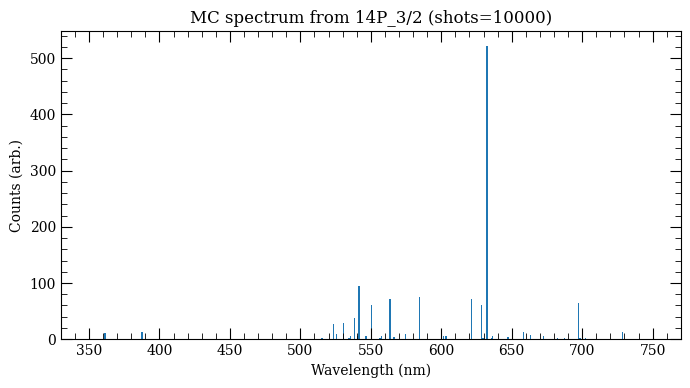

In [22]:
atom = make_atom(ATOM)
wls_m = spectrum_mc(atom, START_STATE, shots=SHOTS, max_steps=MAX_STEPS)

# nm로 변환 후, 가시권만 보기(예: 350–750 nm)
wls_nm = wls_m * 1e9
mask = (wls_nm > 350) & (wls_nm < 750)
wls_nm_vis = wls_nm[mask]

# 500–600 nm 수율(여기당 평균 광자수)
vis_mask = (wls_nm > 500) & (wls_nm < 600)
visible_yield = vis_mask.sum() / SHOTS

print(f"Start: {state_str(START_STATE)} | 샷={SHOTS}, 단계≤{MAX_STEPS}")
print(f"전체 방출수(가시권 350–750 nm): {wls_nm_vis.size}")
print(f"500–600 nm 평균 광자수/여기: {visible_yield:.4f}")

# 히스토그램 (빈 폭은 1nm 권장)
bins = np.arange(350, 751, 1.0)
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(wls_nm_vis, bins=bins)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Counts (arb.)")
ax.set_title(f"MC spectrum from {state_str(START_STATE)} (shots={SHOTS})")
plt.show()

df = pd.DataFrame(wls_nm_vis)

df.to_csv('wls_nm_vis.csv', index=False)

셀 4 — 라인 리스트(대략적인 피크 표)

In [19]:
# 1 nm bin으로 라인-카운트 집계 → 상위 라인 몇 개
counts, edges = np.histogram(wls_nm_vis, bins=np.arange(350, 751, 1.0))
centers = 0.5*(edges[:-1]+edges[1:])
df_lines = (pd.DataFrame({"λ_nm": centers, "counts": counts})
              .query("counts>0")
              .sort_values("counts", ascending=False)
              .head(20)
              .reset_index(drop=True))
df_lines


,λ_nm,counts
0,535.5,1300
1,636.5,46
2,629.5,46
3,663.5,21
4,647.5,21
5,728.5,20
6,387.5,19
7,687.5,19
8,361.5,17
9,706.5,8


어떻게 해석하나요?
히스토그램 봉우리가 바로 **가능한 붕괴선(여러 단계 포함)**의 상대 강도에 해당합니다(샷 수를 늘릴수록 이론적 분포에 수렴).
콘솔에 찍히는 500–600 nm 평균 광자수/여기가 카메라 민감 대역에서의 기대 광자수(= Downes 논문의 pon 계열에 대응)입니다.
시작 상태를 두 후보(예: nP↔(n−1)D) 각각에 대해 돌려서 스펙트럼과 수율을 비교하면, “THz로 어느 쪽 인구를 만들었을 때 변환 효율이 더 좋은가?”를 정량 비교할 수 있습니다.
팁: 실제 THz는 두 상태를 혼합(라비 스플리팅)하므로, 두 스펙트럼의 가중합(가중치는 혼합 계수/점유율)으로 THz-on 스펙트럼을 근사할 수 있어요.